<a href="https://colab.research.google.com/github/pierresegonne/ELEC5307_Project2/blob/master/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTILS

In [1]:
# Install pytorch

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Accelerator: ', accelerator)

print('Installing Torch') 
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl
# Issue with torchvision version
!pip install torchvision==0.2.1
import torch
import torchvision

Accelerator:  cu80
Installing Torch
     |████████████████████████████████| 532.5MB 1.2MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.0 which is incompatible.
     |████████████████████████████████| 61kB 1.9MB/s 
  Found existing installation: torchvision 0.4.1+cu100
    Uninstalling torchvision-0.4.1+cu100:
      Successfully uninstalled torchvision-0.4.1+cu100


In [0]:
ROOT_DIRECTORY = '.'

In [2]:
# Allow saving files to google drive if ran on colab
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIRECTORY = '/content/gdrive/My Drive/Colab Notebooks/ELEC5307 Project2'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def serialize_object(obj, file_name):
    with open(file_name, 'wb') as file_handler:
        pickle.dump(obj, file_handler, protocol=pickle.HIGHEST_PROTOCOL)



# IMPORTS

In [0]:
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pickle
import random

import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder

# MACHINE PARAMETERS

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The following study will use --- {device} --- as device')

cpu_cores = multiprocessing.cpu_count()
print(f'The following study has --- {cpu_cores} --- available cpu cores')

The following study will use --- cuda --- as device
The following study has --- 2 --- available cpu cores


# DATA LOADING AND TRANSFORMATION

In [0]:
SOURCE_FOLDER = '{}/data/Task2/Source'.format(ROOT_DIRECTORY)
TARGET_FOLDER = '{}/data/Task2/Target'.format(ROOT_DIRECTORY)

In [0]:
# Custom image folder for unlabeled target folder.

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def has_file_allowed_extension(filename, extensions):
    return filename.lower().endswith(extensions)

def make_dataset(dir, extensions=None, is_valid_file=None):
  """
  Adaption of https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder
  """
  images = []
  dir = os.path.expanduser(dir)
  if not ((extensions is None) ^ (is_valid_file is None)):
    raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
  if extensions is not None:
    def is_valid_file(x):
      return has_file_allowed_extension(x, extensions)
  for root, _, fnames in sorted(os.walk(dir)):
    for fname in sorted(fnames):
      path = os.path.join(root, fname)
      if is_valid_file(path):
        images.append(path)

  return images

def pil_loader(path):
  # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
  with open(path, 'rb') as f:
    img = Image.open(f)
    img = img.convert('RGB')
    return img

def accimage_loader(path):
  import accimage
  try:
    return accimage.Image(path)
  except IOError:
    # Potentially a decoding problem, fall back to PIL.Image
    return pil_loader(path)

def default_loader(path):
  from torchvision import get_image_backend
  if get_image_backend() == 'accimage':
    return accimage_loader(path)
  else:
    return pil_loader(path)


class TargetImageFolder(Dataset):

  def __init__(self, root, loader, extensions=None, transform=None):
    self.extensions = extensions
    self.loader = loader
    self.samples = make_dataset(root, extensions=IMG_EXTENSIONS)
    self.transform = transform

  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self, index):
    path = self.samples[index]
    sample = self.loader(path)
    if self.transform is not None:
      sample = self.transform(sample)
    return sample, _

In [0]:
SOURCE_NORMALIZATION = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
TARGET_NORMALIZATION = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

source_transform = transforms.Compose([
                                       transforms.RandomResizedCrop(227),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=SOURCE_NORMALIZATION['mean'], std=SOURCE_NORMALIZATION['std']),
])

target_transform = transforms.Compose([
                                       transforms.Resize((227, 227)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=SOURCE_NORMALIZATION['mean'], std=SOURCE_NORMALIZATION['std']),
])

source_set = ImageFolder(SOURCE_FOLDER, transform=source_transform)

target_set = TargetImageFolder(TARGET_FOLDER, default_loader, transform=target_transform, extensions=IMG_EXTENSIONS)


--------
Source Set: 1492 elements. Target Set: 412 elements.
--------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ---- Source Samples
printer stapler scissors printer monitor desk_chair bottle keyboard paper_notebook mobile_phone stapler calculator speaker mobile_phone


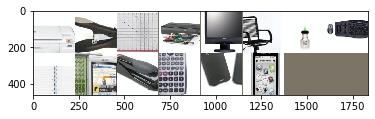

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ---- Target Samples


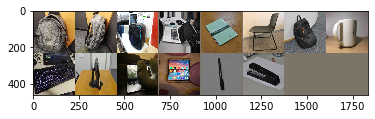

In [9]:
def unnormalize(x, mean, std):
  x = x * np.array(std).reshape(x.shape[0], 1, 1) + np.array(mean).reshape(x.shape[0], 1, 1)
  return x

def showimg(tensor, normalization=None):
    # tensor = tensor / 2 + 0.5     # unnormalize, because normalization is (img - 0.5)/0.5 in transforms.Normalize
    npimg = tensor.numpy()
    if normalization:
      npimg = unnormalize(npimg, normalization['mean'], normalization['std'])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Size of both sets
print(f'--------\nSource Set: {len(source_set)} elements. Target Set: {len(target_set)} elements.\n--------')

# Samples dataloaders
source_loader = DataLoader(source_set, batch_size=14, shuffle=True, num_workers=1)

target_loader = DataLoader(target_set, batch_size=14, shuffle=True, num_workers=1)


# Source Sample
dataiter = source_loader.__iter__()
input, labels = dataiter.next()
print(' ---- Source Samples')
print(' '.join('%5s' % source_set.classes[labels[j]] for j in range(14)))
showimg(torchvision.utils.make_grid(input), SOURCE_NORMALIZATION)

# Target Sample
dataiter = target_loader.__iter__()
input, _ = dataiter.next()
print(' ---- Target Samples')
showimg(torchvision.utils.make_grid(input), TARGET_NORMALIZATION)

# MODEL STRUCTURE



*   https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
*   https://github.com/wogong/pytorch-dann



In [41]:
class Reverse(torch.autograd.Function):

  @staticmethod
  def forward(ctx, x, lbd):
    ctx.lbd = lbd
    return x.view_as(x)
  
  @staticmethod
  def backward(ctx, grad_output):
    output = grad_output.neg() * ctx.lbd
    return output, None


class DANN(nn.Module):

  def __init__(self, number_classes=10):
    super(DANN, self).__init__()

    model_alexnet = torchvision.models.alexnet(pretrained=True)

    self.features = model_alexnet.features

    self.fc = model_alexnet.classifier[:-1] # Remove last layer
    bottleneck_features = model_alexnet.classifier[-1].in_features

    self.bottleneck = nn.Sequential(
      nn.Linear(bottleneck_features, int(bottleneck_features / 2)),
      nn.ReLU(inplace=True),
    )

    self.class_classifier = nn.Sequential(
      nn.Linear(int(bottleneck_features / 2), number_classes)
    )

    self.domain_classifier = nn.Sequential(
      nn.Linear(int(bottleneck_features / 2), 1024), # 1024 is recommended in paper.
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(1024, 1024),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(1024, 2),
    )

  def forward(self, input, lbd=0.1):
    features = self.features(input)
    features = features.view(-1, 256*6*6)
    fc = self.fc(features)
    bottleneck = self.bottleneck(fc)
    reverse_bottleneck = Reverse.apply(bottleneck, lbd)

    predicted_classes = self.class_classifier(bottleneck)
    predicted_domains = self.domain_classifier(reverse_bottleneck)

    return predicted_classes, predicted_domains

dann_test = DANN().to(device)
INPUT_SIZE = (3, 227, 227)
input_random = torch.rand((1, INPUT_SIZE[0], INPUT_SIZE[1], INPUT_SIZE[2])).to(device)
print(dann_test(input_random))

(tensor([[ 0.0999, -0.1433, -0.0180, -0.1777, -0.0372,  0.0790,  0.1385, -0.0857,
         -0.2433,  0.0216]], device='cuda:0', grad_fn=<AddmmBackward>), tensor([[-0.0856,  0.0531]], device='cuda:0', grad_fn=<AddmmBackward>))


# TRAIN

In [0]:
# Utilities for training
def lr_annealing(original_learning_rate, p):
  ALPHA = 10
  BETA = 0.75
  return original_learning_rate / ((1 + (ALPHA * p))**BETA)

def compute_lambda(p):
  GAMMA = 10
  return (2 / (1 + math.exp(-GAMMA * p))) - 1

class Recording(object):

  def __init__(self):
    self.loss = [0]
    self.accuracy = [0]
    self.accuracy_domain = [0]

class Recordings(object):
  def __init__(self):
    self.source = Recording()
    self.target = Recording()

  def log(self, epoch, epochs):
    print(f'\n----- Recording of Evaluation for epoch {epoch + 1}/{epochs}')
    print('Source, loss: {:.4f}, label accuracy: {:.4f}, domain accuracy: {:.4f}'.format(self.source.loss[-1], self.source.accuracy[-1], self.source.accuracy_domain[-1]))
    print('Target, loss: {:.4f}, label accuracy: {:.4f}, domain accuracy: {:.4f}'.format(self.target.loss[-1], self.target.accuracy[-1], self.target.accuracy_domain[-1]))


In [0]:
def pre_train(model, source_loader, device):
  # Is it even necessary? Not sure if we use alexnet
  pass

In [0]:
def evaluate(model, loader, device, flag_source):
  # Eval flag
  model.eval()

  # Initialize metrics
  loss = 0.
  accuracy = 0.
  accuracy_domain = 0.

  # Criterion
  criterion = nn.CrossEntropyLoss() # From paper

  with torch.no_grad():
    for (inputs, labels) in loader:

      # To device
      inputs = inputs.to(device)
      if flag_source == True:
        labels = labels.to(device)

      # Prepare domain labels
      if flag_source == True:
        domains = torch.zeros(len(inputs)).float().to(device)
      else:
        domains = torch.ones(len(inputs)).float().to(device)
      
      label_outputs, domain_outputs = model(inputs, lbd=0)

      # Update loss
      if flag_source == True:
        loss += criterion(label_outputs, labels).data.item()

      # Update Accuracies
      predicted_labels = label_outputs.data.max(1)[1]
      if flag_source == True:
        accuracy += predicted_labels.eq(labels.data).sum().item()
      predicted_domains = domain_outputs.data.max(1)[1]
      accuracy_domain += predicted_domains.eq(domains.data).sum().item()

  # Average metrics
  loss /= len(loader)
  accuracy /= len(loader.dataset)
  accuracy_domain /= len(loader.dataset)

  return loss, accuracy, accuracy_domain



In [0]:
def train(model, optimizer, criterion, source_loader, target_loader, device, params):
  print('==== Start Training ====')

  for epoch in range(params.epochs):
    # Train flag
    model.train()

    # Mixed loader
    loader = zip(source_loader, target_loader)
    len_loader = min(len(source_loader), len(target_loader)) # Avoid doing list(zip(...)) for performance

    # Recordings
    recordings = Recordings()
    for iteration, ((source_inputs, source_labels), (target_inputs, _)) in enumerate(loader):

      # Training progress p
      p = (epoch * len_loader + iteration) / (params.epochs * len_loader) # progress, linearly from 0 to 1
      lbd = compute_lambda(p)
      adjusted_lr = lr_annealing(params.learning_rate, p)
      for param_group in optimizer.param_groups:
        param_group['lr'] = adjusted_lr

      # To device
      source_inputs = source_inputs.to(device)
      source_labels = source_labels.to(device)
      target_inputs = target_inputs.to(device)

      # Prepare domain labels
      source_domains = torch.zeros(len(source_inputs)).long().to(device)
      target_domains = torch.ones(len(target_inputs)).long().to(device)

      # Reset grad
      optimizer.zero_grad()

      # Source domain
      source_label_outputs, source_domain_outputs = model(source_inputs, lbd=lbd)
      source_labels_loss = criterion(source_label_outputs, source_labels)
      source_domains_loss = criterion(source_domain_outputs, source_domains)

      # Target domain
      _, target_domain_outputs = model(target_inputs, lbd=lbd)
      target_domains_loss = criterion(target_domain_outputs, target_domains)

      # Combine losses
      loss = source_labels_loss + source_domains_loss + target_domains_loss

      # Optimize
      loss.backward()
      optimizer.step()

      # =======
      # Log Progress
      if ((iteration + 1) % params.log_progress_every == 0):
        print(f'\n---- Epoch {epoch + 1}/{params.epochs}, Iteration {iteration + 1}/{len_loader}')
        print('Source, label loss: {:.4f}, domain loss: {:.4f} || Target, domain loss: {:.4f}'.format(source_labels_loss.data.item(), source_domains_loss.data.item(), target_domains_loss.data.item()))
        print('Overall loss : {:.4f}'.format(loss.data.item()))

    # Evaluate
    if ((epoch + 1) % params.evaluate_model_every == 0):
      source_loss, source_accuracy, source_accuracy_domain = evaluate(model, source_loader, device, True)
      recordings.source.loss.append(source_loss); recordings.source.accuracy.append(source_accuracy); recordings.source.accuracy_domain.append(source_accuracy_domain)
      
      target_loss, target_accuracy, target_accuracy_domain = evaluate(model, target_loader, device, False)
      recordings.target.loss.append(target_loss); recordings.target.accuracy.append(target_accuracy); recordings.target.accuracy_domain.append(target_accuracy_domain)
      
      recordings.log(epoch, params.epochs)

    # Save temporary model
    if ((epoch + 1) % params.save_model_every == 0):
      torch.save(model.state_dict(), params.model_filename)

  # Save final model
  torch.save(model.state_dict(), params.model_filename)

  # Save recordings
  serialize_object(recordings, params.recordings_filename)

  print('\n==== END TRAINING ====')
  
  return model, recordings

# PARAMETERS

In [0]:
class Params(object):

  batch_size_source = 128 // 2 # From paper
  batch_size_target = 128 // 2
  epochs = 5
  learning_rate = 0.01 # From paper
  momentum = 0.9
  weight_decay = 0

  log_progress_every = 2 # In iterations
  evaluate_model_every = 1 # In epochs
  save_model_every = 10 # In epochs

  model_filename = '{}/saves_task2/dann.pth'.format(ROOT_DIRECTORY)
  recordings_filename = '{}/saves_task2/recordings.pickle'.format(ROOT_DIRECTORY)

In [0]:
# Model, optimizer and criterion
params = Params()
model = DANN(number_classes=len(source_set.classes)).to(device)
optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=params.momentum, weight_decay=params.weight_decay)
criterion = nn.CrossEntropyLoss()

# Loaders
# Massive bugs with multiprocessing..
# source_loader = DataLoader(source_set, batch_size=params.batch_size_source, shuffle=True, num_workers=cpu_cores)
# target_loader = DataLoader(target_set, batch_size=params.batch_size_target, shuffle=True, num_workers=cpu_cores)
# No multiprocessing
source_loader = DataLoader(source_set, batch_size=params.batch_size_source, shuffle=True)
target_loader = DataLoader(target_set, batch_size=params.batch_size_target, shuffle=True)

# RUN

In [124]:
model, recordings = train(model, optimizer, criterion, source_loader, target_loader, device, params)

==== Start Training ====

---- Epoch 1/5, Iteration 2/7
Source, label loss: 2.7076, domain loss: 0.6773 || Target, domain loss: 0.7196
Overall loss : 4.1045

---- Epoch 1/5, Iteration 4/7
Source, label loss: 2.4907, domain loss: 0.6916 || Target, domain loss: 0.6791
Overall loss : 3.8614

---- Epoch 1/5, Iteration 6/7
Source, label loss: 2.1626, domain loss: 0.7095 || Target, domain loss: 0.6482
Overall loss : 3.5203

----- Recording of Evaluation for epoch 1/5
Source, loss: 1.6604, label accuracy: 0.6139, domain accuracy: 0.1535
Target, loss: 0.0000, label accuracy: 0.0000, domain accuracy: 0.9927

---- Epoch 2/5, Iteration 2/7
Source, label loss: 1.5522, domain loss: 0.7124 || Target, domain loss: 0.6398
Overall loss : 2.9044

---- Epoch 2/5, Iteration 4/7
Source, label loss: 1.3275, domain loss: 0.6731 || Target, domain loss: 0.6583
Overall loss : 2.6589

---- Epoch 2/5, Iteration 6/7
Source, label loss: 1.3411, domain loss: 0.6377 || Target, domain loss: 0.7152
Overall loss : 2.693

# TEST

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ---- Source Samples


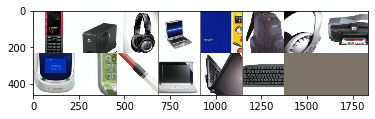

True Labels
mobile_phone speaker headphones laptop_computer paper_notebook back_pack headphones printer mobile_phone mobile_phone   pen laptop_computer laptop_computer keyboard
Predicted Labels
mobile_phone speaker headphones laptop_computer paper_notebook back_pack headphones printer mobile_phone scissors   pen laptop_computer bottle keyboard


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ---- Target Samples


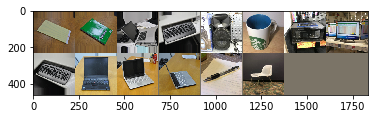

Predicted Labels
paper_notebook paper_notebook speaker keyboard speaker   mug mobile_phone monitor keyboard laptop_computer laptop_computer paper_notebook stapler printer


In [125]:
# Samples dataloaders
source_loader = DataLoader(source_set, batch_size=14, shuffle=True)
target_loader = DataLoader(target_set, batch_size=14, shuffle=True)

# Source Sample
dataiter = source_loader.__iter__()
input, labels = dataiter.next()
print(' ---- Source Samples')
showimg(torchvision.utils.make_grid(input), SOURCE_NORMALIZATION)
print('True Labels')
print(' '.join('%5s' % source_set.classes[labels[j]] for j in range(14)))
print('Predicted Labels')
input = input.to(device)
label_output, _ = model(input, lbd=0)
predicted_labels = label_output.data.max(1)[1]
print(' '.join('%5s' % source_set.classes[predicted_labels[j]] for j in range(14)))


# Target Sample
dataiter = target_loader.__iter__()
input, _ = dataiter.next()
print(' ---- Target Samples')
showimg(torchvision.utils.make_grid(input), TARGET_NORMALIZATION)
print('Predicted Labels')
input = input.to(device)
label_output, _ = model(input, lbd=0)
predicted_labels = label_output.data.max(1)[1]
print(' '.join('%5s' % source_set.classes[predicted_labels[j]] for j in range(14)))

Reflexions:

Should we reset the source loader at every epoch to explore a larger amount of samples from source?